# Post Hoc Explaination on Loan

# Setup

In [2]:
# import joblib
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import metrics

import lime
import shap

from utils.xailib.explainers.lore_explainer import LoreTabularExplainer
from utils.xailib.models.sklearn_classifier_wrapper import sklearn_classifier_wrapper
from utils.xailib.data_loaders.dataframe_loader import prepare_dataframe

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Input Data Preparation


We start by reading our data.

We are going to work on the adult dataset. It is a classic, benchmark tabular dataset, designed for a classification task.

The Adult dataset classifies people as high ($\geq$ 50k) or low ($\leq$50k) income.

We read our data from a .csv file into a `pandas` `DataFrame`.

In [3]:
filename = 'data/bank_data.csv'
loan = pd.read_csv(filename, skipinitialspace=True, na_values='?', keep_default_na=True)
loan.head()

Loan ID                           Customer ID  \
0  14dd8831-6af5-400b-83ec-68e61888a048  981165ec-3274-42f5-a3b4-d104041a9ca9   
1  4771cc26-131a-45db-b5aa-537ea4ba5342  2de017a3-2e01-49cb-a581-08169e83be29   
2  4eed4e6a-aa2f-4c91-8651-ce984ee8fb26  5efb2b2b-bf11-4dfd-a572-3761a2694725   
3  77598f7b-32e7-4e3b-a6e5-06ba0d98fe8a  e777faab-98ae-45af-9a86-7ce5b33b1011   
4  d4062e70-befa-4995-8643-a0de73938182  81536ad9-5ccf-4eb8-befb-47a4d608658e   

  Loan Status  Current Loan Amount        Term  Credit Score  Annual Income  \
0  Fully Paid             445412.0  Short Term         709.0      1167493.0   
1  Fully Paid             262328.0  Short Term           NaN            NaN   
2  Fully Paid           99999999.0  Short Term         741.0      2231892.0   
3  Fully Paid             347666.0   Long Term         721.0       806949.0   
4  Fully Paid             176220.0  Short Term           NaN            NaN   

  Years in current job Home Ownership             Purpose  Monthly Debt  \
0              8 years  Home Mortgage   Home Improvements       5214.74   
1            10+ years  Home Mortgage  Debt Consolidation      33295.98   
2              8 years       Own Home  Debt Consolidation      29200.53   
3              3 years       Own Home  Debt Consolidation       8741.90   
4              5 years           Rent  Debt Consolidation      20639.70   

   Years of Credit History  Months since last delinquent  \
0                     17.2                           NaN   
1                     21.1                           8.0   
2                     14.9                          29.0   
3                     12.0                           NaN   
4                      6.1                           NaN   

   Number of Open Accounts  Number of Credit Problems  Current Credit Balance  \
0                      6.0                        1.0                228190.0   
1                     35.0                        0.0                229976.0   
2                     18.0                        1.0                297996.0   
3                      9.0                        0.0                256329.0   
4                     15.0                        0.0                253460.0   

   Maximum Open Credit  Bankruptcies  Tax Liens  
0             416746.0           1.0        0.0  
1             850784.0           0.0        0.0  
2             750090.0           0.0        0.0  
3             386958.0           0.0        0.0  
4             427174.0           0.0        0.0

`Loan Status` is our target variable, the one that we want to predict

In [4]:
loan.drop(columns=["Loan ID", "Customer ID", "Months since last delinquent"], inplace=True)

In [5]:
loan

Loan Status  Current Loan Amount        Term  Credit Score  \
0       Fully Paid             445412.0  Short Term         709.0   
1       Fully Paid             262328.0  Short Term           NaN   
2       Fully Paid           99999999.0  Short Term         741.0   
3       Fully Paid             347666.0   Long Term         721.0   
4       Fully Paid             176220.0  Short Term           NaN   
...            ...                  ...         ...           ...   
100509         NaN                  NaN         NaN           NaN   
100510         NaN                  NaN         NaN           NaN   
100511         NaN                  NaN         NaN           NaN   
100512         NaN                  NaN         NaN           NaN   
100513         NaN                  NaN         NaN           NaN   

        Annual Income Years in current job Home Ownership             Purpose  \
0           1167493.0              8 years  Home Mortgage   Home Improvements   
1                 NaN            10+ years  Home Mortgage  Debt Consolidation   
2           2231892.0              8 years       Own Home  Debt Consolidation   
3            806949.0              3 years       Own Home  Debt Consolidation   
4                 NaN              5 years           Rent  Debt Consolidation   
...               ...                  ...            ...                 ...   
100509            NaN                  NaN            NaN                 NaN   
100510            NaN                  NaN            NaN                 NaN   
100511            NaN                  NaN            NaN                 NaN   
100512            NaN                  NaN            NaN                 NaN   
100513            NaN                  NaN            NaN                 NaN   

        Monthly Debt  Years of Credit History  Number of Open Accounts  \
0            5214.74                     17.2                      6.0   
1           33295.98                     21.1                     35.0   
2           29200.53                     14.9                     18.0   
3            8741.90                     12.0                      9.0   
4           20639.70                      6.1                     15.0   
...              ...                      ...                      ...   
100509           NaN                      NaN                      NaN   
100510           NaN                      NaN                      NaN   
100511           NaN                      NaN                      NaN   
100512           NaN                      NaN                      NaN   
100513           NaN                      NaN                      NaN   

        Number of Credit Problems  Current Credit Balance  \
0                             1.0                228190.0   
1                             0.0                229976.0   
2                             1.0                297996.0   
3                             0.0                256329.0   
4                             0.0                253460.0   
...                           ...                     ...   
100509                        NaN                     NaN   
100510                        NaN                     NaN   
100511                        NaN                     NaN   
100512                        NaN                     NaN   
100513                        NaN                     NaN   

        Maximum Open Credit  Bankruptcies  Tax Liens  
0                  416746.0           1.0        0.0  
1                  850784.0           0.0        0.0  
2                  750090.0           0.0        0.0  
3                  386958.0           0.0        0.0  
4                  427174.0           0.0        0.0  
...                     ...           ...        ...  
100509                  NaN           NaN        NaN  
100510                  NaN           NaN        NaN  
100511                  NaN           NaN        NaN  
100512                  NaN      

In [6]:
target = 'Loan Status'

We can look at some summary to have an idea of how our data is distributed

In [7]:
loan.describe()

Current Loan Amount  Credit Score  Annual Income   Monthly Debt  \
count         1.000000e+05  80846.000000   8.084600e+04  100000.000000   
mean          1.176045e+07   1076.456089   1.378277e+06   18472.412336   
std           3.178394e+07   1475.403791   1.081360e+06   12174.992609   
min           1.080200e+04    585.000000   7.662700e+04       0.000000   
25%           1.796520e+05    705.000000   8.488440e+05   10214.162500   
50%           3.122460e+05    724.000000   1.174162e+06   16220.300000   
75%           5.249420e+05    741.000000   1.650663e+06   24012.057500   
max           1.000000e+08   7510.000000   1.655574e+08  435843.280000   

       Years of Credit History  Number of Open Accounts  \
count            100000.000000             100000.00000   
mean                 18.199141                 11.12853   
std                   7.015324                  5.00987   
min                   3.600000                  0.00000   
25%                  13.500000                  8.00000   
50%                  16.900000                 10.00000   
75%                  21.700000                 14.00000   
max                  70.500000                 76.00000   

       Number of Credit Problems  Current Credit Balance  Maximum Open Credit  \
count              100000.000000            1.000000e+05         9.999800e+04   
mean                    0.168310            2.946374e+05         7.607984e+05   
std                     0.482705            3.761709e+05         8.384503e+06   
min                     0.000000            0.000000e+00         0.000000e+00   
25%                     0.000000            1.126700e+05         2.734380e+05   
50%                     0.000000            2.098170e+05         4.678740e+05   
75%                     0.000000            3.679588e+05         7.829580e+05   
max                    15.000000            3.287897e+07         1.539738e+09   

       Bankruptcies     Tax Liens  
count  99796.000000  99990.000000  
mean       0.117740      0.029313  
std        0.351424      0.258182  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0.000000      0.000000  
max        7.000000     15.000000

In [8]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100514 entries, 0 to 100513
Data columns (total 16 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Loan Status                100000 non-null  object 
 1   Current Loan Amount        100000 non-null  float64
 2   Term                       100000 non-null  object 
 3   Credit Score               80846 non-null   float64
 4   Annual Income              80846 non-null   float64
 5   Years in current job       95778 non-null   object 
 6   Home Ownership             100000 non-null  object 
 7   Purpose                    100000 non-null  object 
 8   Monthly Debt               100000 non-null  float64
 9   Years of Credit History    100000 non-null  float64
 10  Number of Open Accounts    100000 non-null  float64
 11  Number of Credit Problems  100000 non-null  float64
 12  Current Credit Balance     100000 non-null  float64
 13  Maximum Open Credit        99

After the data is loaded in memory, we need to extract metadata information to automatically handle the content withint the table.

We can do this on our own, but the loader method `prepare_dataframe` can make a lot of work for us.
The method `prepare_dataframe` scans the table and extract the following information:

- `df`: is a trasformed version of the original dataframe, where discrete attributes are transformed into numerical attributes by using one hot encoding strategy;
- `feature_names`: is a list containing the names of the features after the transformation;
- `class_values`: the list of all the possible values for the class_field column;
- `numeric_columns`: a list of the original features that contain numeric (i.e. continuous) values;
- `rdf`: the original dataframe, before the transformation;
- `real_feature_names`: the list of the features of the dataframe before the transformation;
- `features_map`: it is a dictionary pointing each feature to the original one before the transformation.

In [117]:
df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = prepare_dataframe(loan, target)

# Let's train a black box on our data

Now that the data is ready we can train a classifier on it. Let's try the classic `random forest classifier`.


First, we split train and test

In [118]:
test_size = 0.3
random_state = 42
X_train, X_test, Y_train, Y_test = train_test_split(df[feature_names], df[target],
                                                        test_size=test_size,
                                                        random_state=random_state,
                                                        stratify=df[target])

In [119]:
df.rename(columns = {'Years in current job=< 1 year':'Years in current job= 1- year'}, inplace=True)
X_train.rename(columns = {'Years in current job=< 1 year':'Years in current job= 1- year'}, inplace=True)
X_test.rename(columns = {'Years in current job=< 1 year':'Years in current job= 1- year'}, inplace=True)

We can then create our black box and train it.
We should do some hyper parameter search first, possibly with cross validation, but this is just an example

In [12]:
bb = RandomForestClassifier(n_estimators=20, random_state=random_state)
bb.fit(X_train.values, Y_train.values)

RandomForestClassifier(n_estimators=20, random_state=42)

In [13]:
Y_pred = bb.predict(X_train)
print(classification_report(Y_train, Y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     15847
           1       1.00      1.00      1.00     54512

    accuracy                           1.00     70359
   macro avg       1.00      1.00      1.00     70359
weighted avg       1.00      1.00      1.00     70359



In [14]:
Y_pred = bb.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.74      0.28      0.41      6792
           1       0.82      0.97      0.89     23363

    accuracy                           0.82     30155
   macro avg       0.78      0.63      0.65     30155
weighted avg       0.80      0.82      0.78     30155



Obviously, train and test present very different metrics.
Now we can apply a post-hoc explanation method to our black box.

I will also train an alternative model, an xgboost classifier. The reason will become clear shortly.

In [15]:
xgbclf = xgb.XGBClassifier().fit(X_train, Y_train)

# SHAP


SHAP uses game theory and shapley values to provide an explanation.

The general working of SHAP in the classical Kernel mode (default mode) is:

- Sample coalitions $z_k'\in\{0,1\}^M,\quad{}k\in\{1,\ldots,K\}$ (1 = feature present in coalition, 0 = feature absent).
- Get prediction for each $z_k'$ by first converting $z_k'$ to the original feature space and then applying model $\hat{f}: \hat{f}(h_x(z_k'))$
- Compute the weight for each $z_k'$ with the SHAP kernel.
- Fit weighted linear model.
- Return Shapley values $\phi_k$, the coefficients from the linear model.

SHAP provides several explanators, optimized for different objectives, and several visualization options.

- Kernel Explainer, it is the *real* agnostic method for computing Shap values. Hence, it works for every kind of ML model (quite slow).
- Linear Explainer, for explaining linear models. It is an exact method. It allows for an analysis with independent variables, as well as for correlated ones (you have to estimates the variables covariance matrix).
- Tree Explainer, for explaining tree-based models (tree and ensambles). Is is an exact algorithm. (Difference: conditional expectation $E_{X_j|X_{-j}}(\hat{f}(x)|x_j)$)
- Gradient Explainer, for explaining deep learning models. It is based on Integrated Gradient and it is an approximation algorithm.
- Deep Explainer, for explaining deep learning models. It is based on DEEPLift and the method computes an approximation algorithm (faster than Gradient Explainer).

For our random forest we can use the tree explainer

In [16]:
shap_tree_exp = shap.TreeExplainer(bb)
shap_values_tree = shap_tree_exp.shap_values(X_test[0:200])

In [17]:
shap_values_tree

[array([[ 1.30892302e-02, -3.99564251e-02, -4.36223776e-02, ...,
         -5.18076443e-04, -8.84299750e-05, -5.60882195e-05],
        [ 3.47872934e-02, -1.91847229e-02, -2.56984741e-02, ...,
         -5.15901701e-04, -2.89584647e-05, -8.45835054e-06],
        [ 5.09807390e-02, -2.80651252e-02,  3.07914199e-02, ...,
         -2.48743173e-04, -1.41704778e-05, -5.96737496e-05],
        ...,
        [ 4.09948771e-02, -5.59370658e-02, -1.07549240e-01, ...,
         -4.40566976e-04, -2.90740900e-05, -1.13328120e-05],
        [ 3.63840495e-03, -5.37342113e-02, -4.56104775e-02, ...,
         -5.28762948e-04, -3.22631359e-05, -3.08872213e-05],
        [ 5.68597483e-02, -2.95877934e-02,  2.32167327e-02, ...,
         -4.40144862e-04, -8.62763073e-05, -8.11995415e-05]]),
 array([[-1.30892302e-02,  3.99564251e-02,  4.36223776e-02, ...,
          5.18076443e-04,  8.84299750e-05,  5.60882194e-05],
        [-3.47872934e-02,  1.91847229e-02,  2.56984741e-02, ...,
          5.15901701e-04,  2.89584647e

The summary plot gives us an overall view of the shapley values for a bunch of records

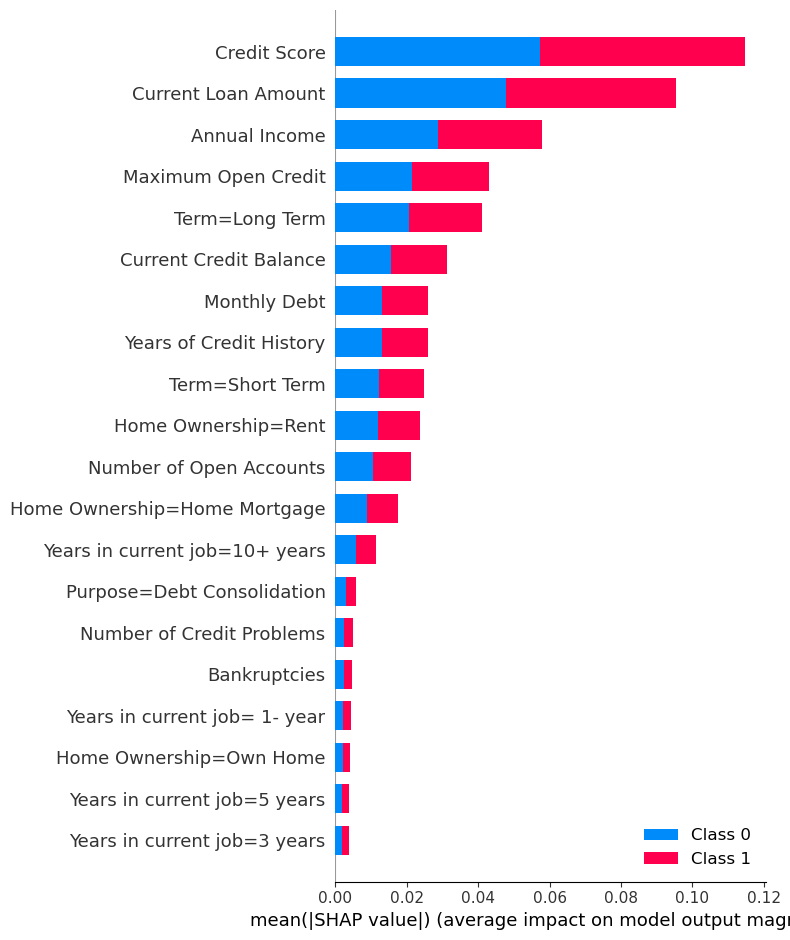

In [18]:
shap.summary_plot(shap_values_tree, X_test[0:200])

In [19]:
tree_explanation_object = shap_tree_exp(X_test[0:200])

In [20]:
tree_explanation_object

.values =
array([[[ 1.30892302e-02, -1.30892302e-02],
        [-3.99564251e-02,  3.99564251e-02],
        [-4.36223776e-02,  4.36223776e-02],
        ...,
        [-5.18076443e-04,  5.18076443e-04],
        [-8.84299750e-05,  8.84299750e-05],
        [-5.60882195e-05,  5.60882194e-05]],

       [[ 3.47872934e-02, -3.47872934e-02],
        [-1.91847229e-02,  1.91847229e-02],
        [-2.56984741e-02,  2.56984741e-02],
        ...,
        [-5.15901701e-04,  5.15901701e-04],
        [-2.89584647e-05,  2.89584647e-05],
        [-8.45835054e-06,  8.45835054e-06]],

       [[ 5.09807390e-02, -5.09807390e-02],
        [-2.80651252e-02,  2.80651252e-02],
        [ 3.07914199e-02, -3.07914199e-02],
        ...,
        [-2.48743173e-04,  2.48743173e-04],
        [-1.41704778e-05,  1.41704778e-05],
        [-5.96737496e-05,  5.96737496e-05]],

       ...,

       [[ 4.09948771e-02, -4.09948771e-02],
        [-5.59370658e-02,  5.59370658e-02],
        [-1.07549240e-01,  1.07549240e-01],
        

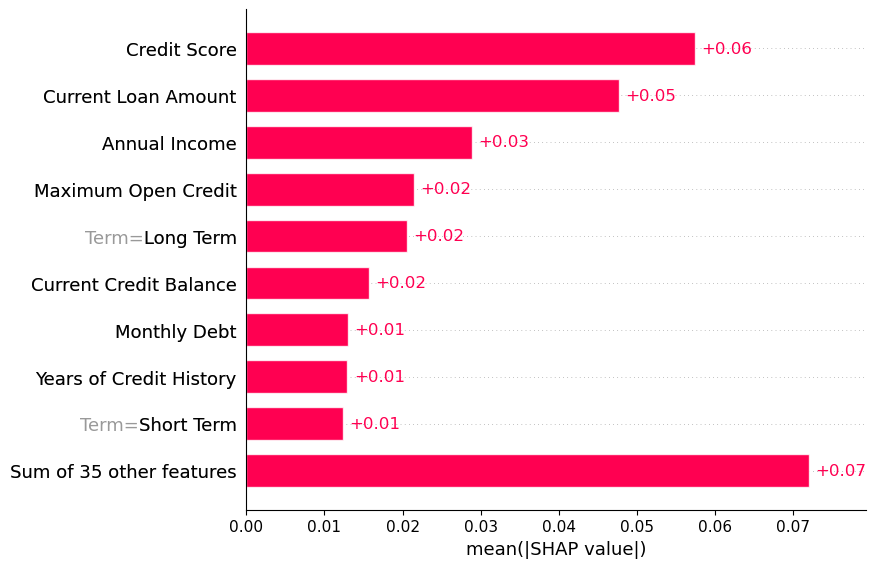

In [21]:
shap.plots.bar(tree_explanation_object[:,:,0])

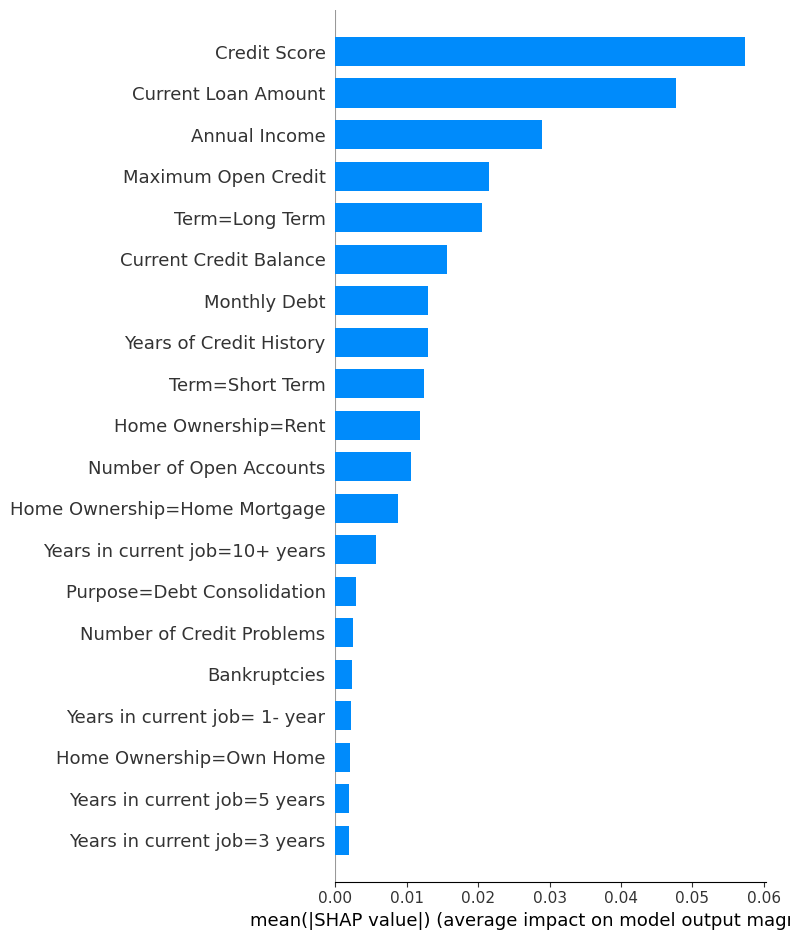

In [22]:
shap.summary_plot(shap_values_tree[0], X_test[0:200], plot_type='bar')

In [23]:
xgb_shap_tree_exp = shap.TreeExplainer(xgbclf)
xgb_shap_values_tree = xgb_shap_tree_exp.shap_values(X_test[0:200])

In [24]:
xgb_shap_values_tree

array([[-8.5276976e-02,  2.8899038e-02,  6.6939080e-01, ...,
         3.2545254e-03,  2.0472413e-04,  0.0000000e+00],
       [-1.6537116e-01, -1.7343413e-02,  4.1755697e-01, ...,
         1.3194776e-03,  1.0000392e-04,  0.0000000e+00],
       [-3.3528611e-01,  2.2440003e-01, -3.1389606e-01, ...,
         3.1837954e-03,  7.3335490e-05,  0.0000000e+00],
       ...,
       [-6.6409099e-01,  4.5003155e-01,  6.5677994e-01, ...,
         2.8975578e-03,  2.1886155e-04,  0.0000000e+00],
       [ 9.7203955e-02,  5.3532821e-01,  2.9486427e-01, ...,
         3.6348240e-03,  1.0000392e-04,  0.0000000e+00],
       [-4.4077298e-01,  2.4195713e-01, -2.4557395e-02, ...,
         1.0943018e-03,  2.0472413e-04,  0.0000000e+00]], dtype=float32)

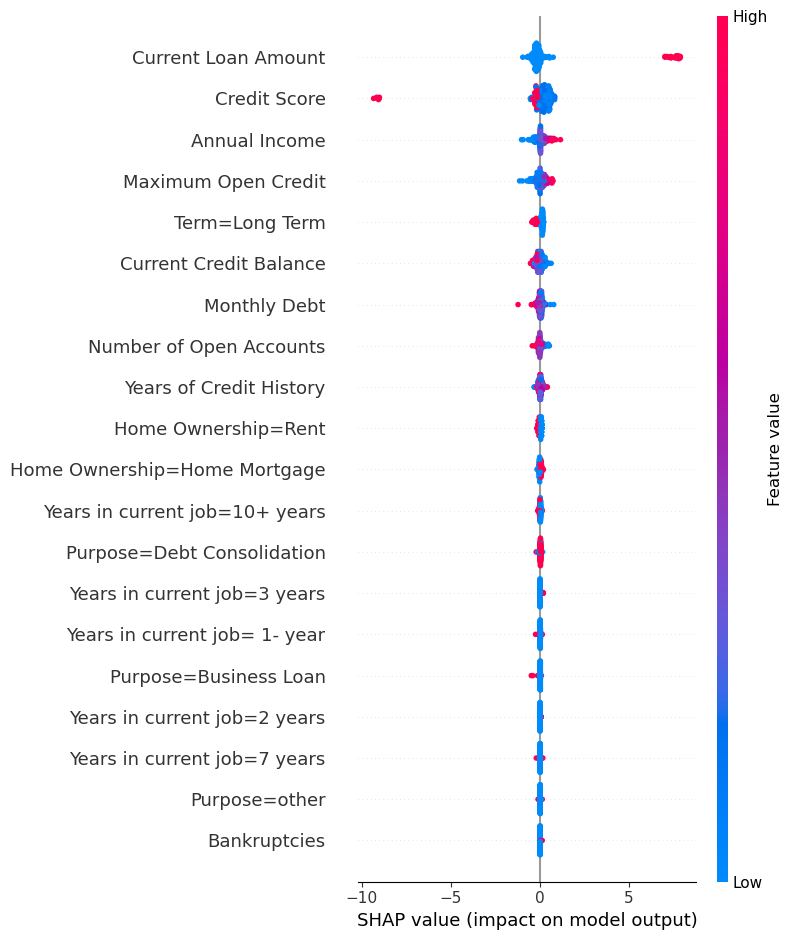

In [25]:
shap.summary_plot(xgb_shap_values_tree, X_test[0:200])

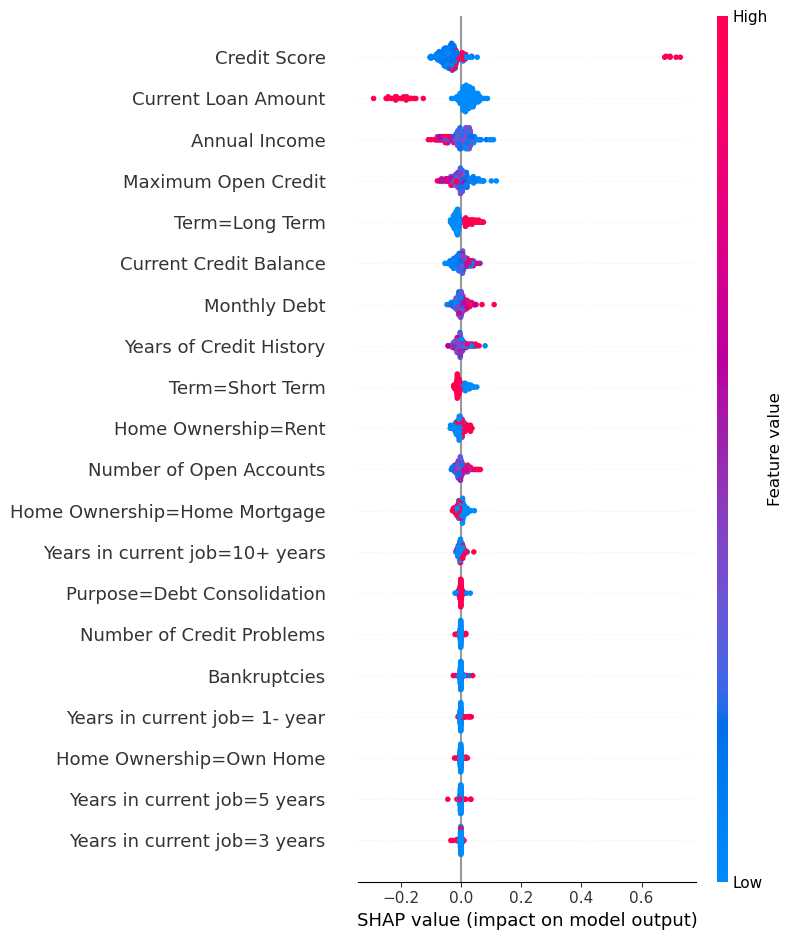

In [26]:
shap.summary_plot(shap_values_tree[0], X_test[0:200])

We can use dependence plot to focus on one variable.

- Each dot is a single prediction (row) from the dataset.
- The x-axis is the value of the feature (from the X matrix).
- The y-axis is the SHAP value for that feature, which represents how much knowing that feature’s value changes the output of the model for that sample’s prediction.
- The color corresponds to a second feature that may have an interaction effect with the feature we are plotting (by default this second feature is chosen automatically). If an interaction effect is present between this other feature and the feature we are plotting it will show up as a distinct vertical pattern of coloring.

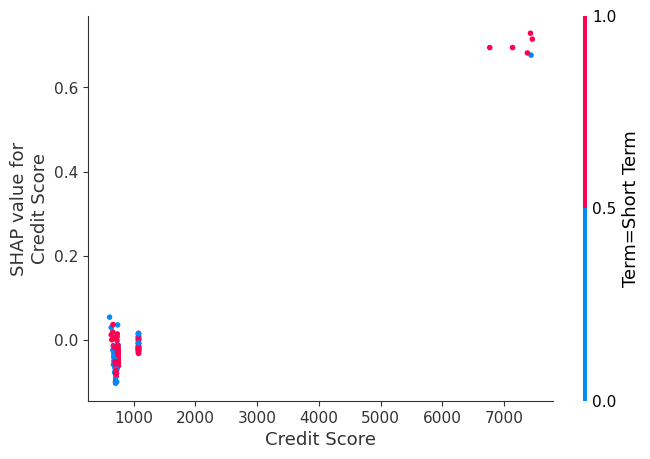

In [27]:
shap.dependence_plot("Credit Score", shap_values_tree[0], X_test[0:200])

We can explore the interactions between variables.
SHAP interaction values are a generalization of SHAP values to higher order interactions.
A summary plot of a SHAP interaction value matrix plots a matrix of summary plots with the main effects on the diagonal and the interaction effects off the diagonal.

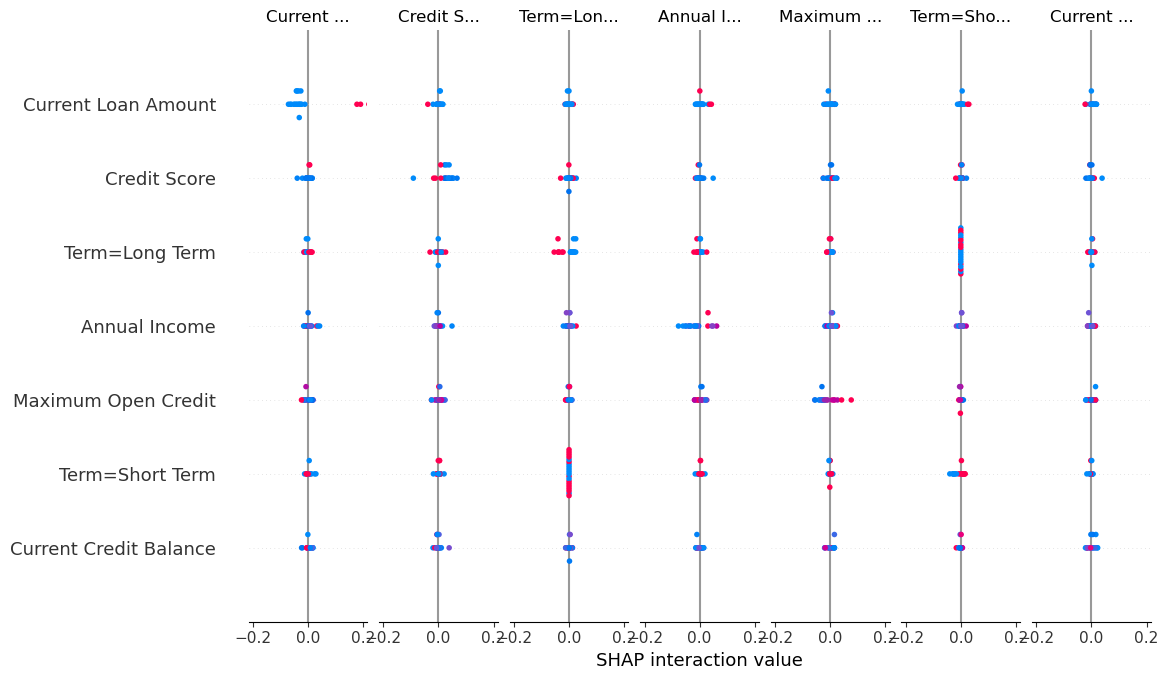

In [28]:
shap_interaction_values_tree = shap_tree_exp.shap_interaction_values(X_test.iloc[0:20])
shap.summary_plot(shap_interaction_values_tree[1], X_test.iloc[0:20])

Running a dependence plot on the SHAP interaction values a allows us to separately observe the main effects and the interaction effects.

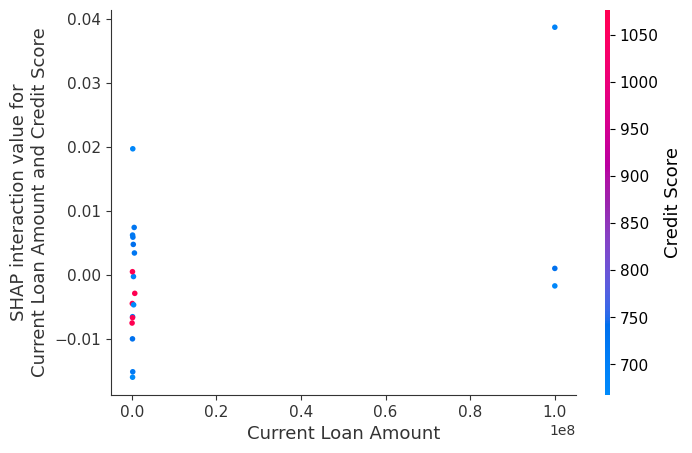

In [29]:
shap.dependence_plot(
    ("Current Loan Amount", "Credit Score"),
    shap_interaction_values_tree[0], X_test.iloc[0:20]
)


SHAP also provides some nice interactive visualizations using javascript

In [30]:
shap.initjs()
shap.force_plot(shap_tree_exp.expected_value[0], shap_values_tree[0], X_test[0:200])

For now we've explored our model on a global level. Let's now look at local explanation using SHAP.

In [31]:
shap.initjs()
shap.force_plot(shap_tree_exp.expected_value[0], shap_values_tree[0][0,:], feature_names)

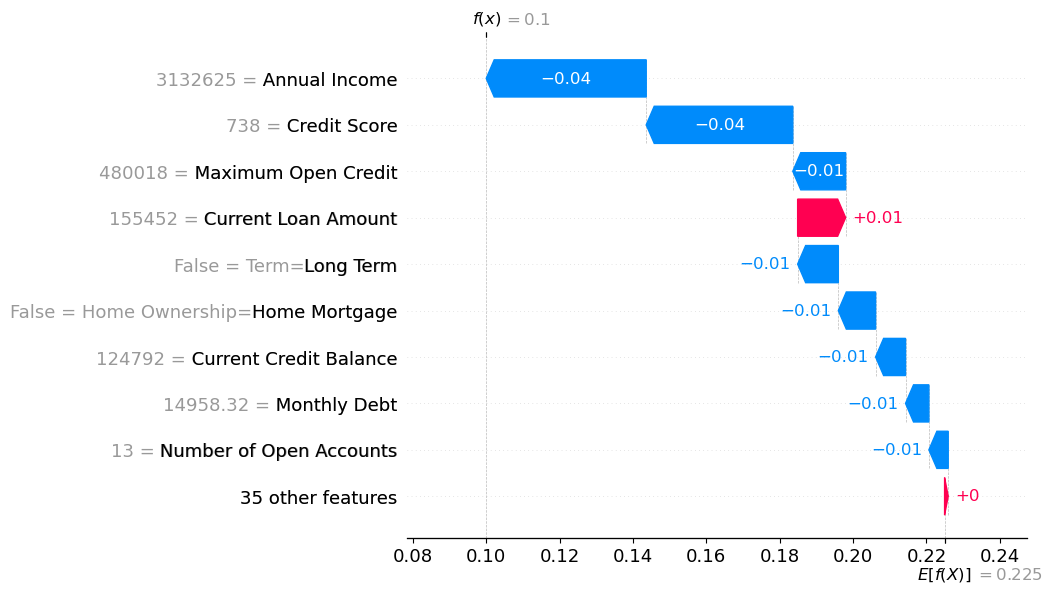

In [32]:
shap.plots.waterfall(tree_explanation_object[:,:,0][0])

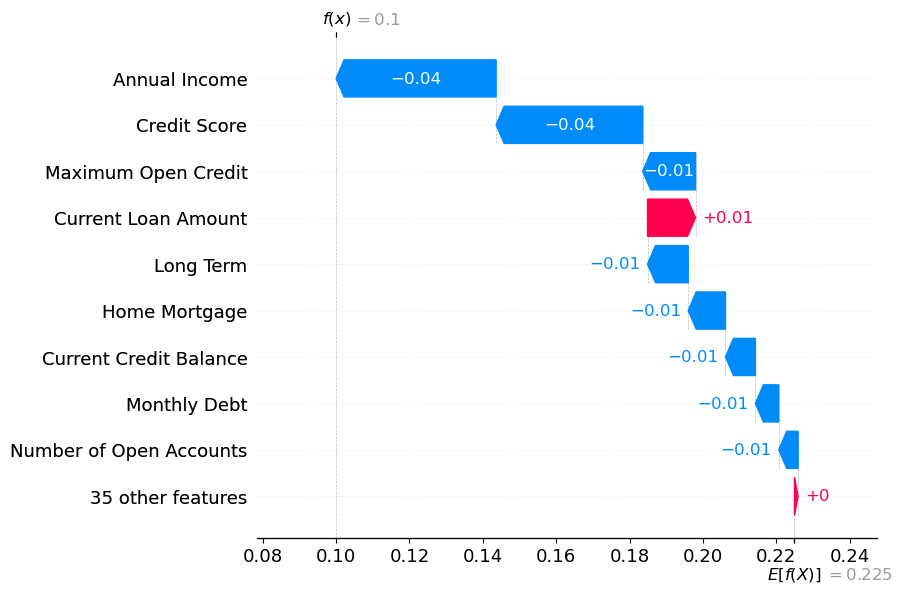

In [33]:
shap.plots._waterfall.waterfall_legacy(shap_tree_exp.expected_value[0], shap_values_tree[0][0,:], feature_names=feature_names)

Another example

Let's try a different explainer: before we used the TreeExplainer, but there are other explainers available in SHAP. Since we are dealing with a RandomForest, another possibility could be the KernelExplainer, that is completley agnostic.

KernelExplainer requires in input the predict_proba of the black-box we want to explain and a sample of the data. In this simple example we use just the first 20 records of the test set, but in principle you can pass whatever representation of your data, such as the centroids obtained from a clustering algorithm.

In [34]:
shap_kernel_exp = shap.KernelExplainer(bb.predict_proba, X_test[0:20])
shap_values_kernel = shap_kernel_exp.shap_values(X_test[0:200])

  0%|          | 0/200 [00:00<?, ?it/s]

Let's now see how the explanation change

In [35]:
shap.initjs()
shap.force_plot(shap_kernel_exp.expected_value[0], shap_values_kernel[0], X_test[0:200])

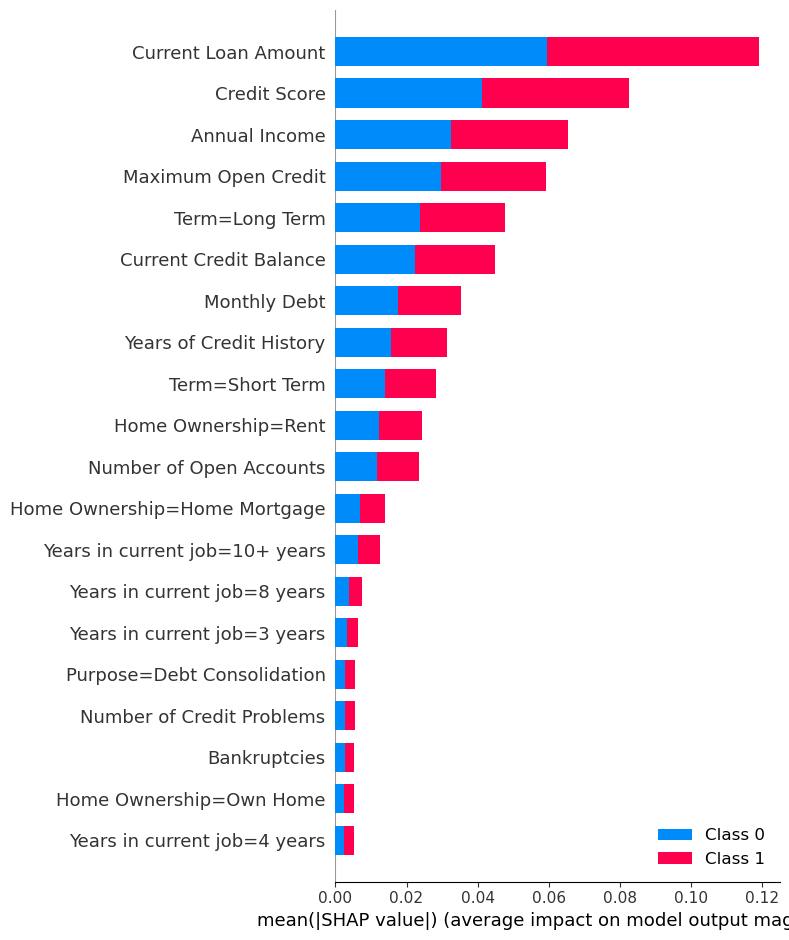

In [36]:
shap.summary_plot(shap_values_kernel, X_test[0:200])

In [37]:
shap.initjs()
shap.force_plot(shap_kernel_exp.expected_value[1], shap_values_kernel[1][1,:], feature_names)

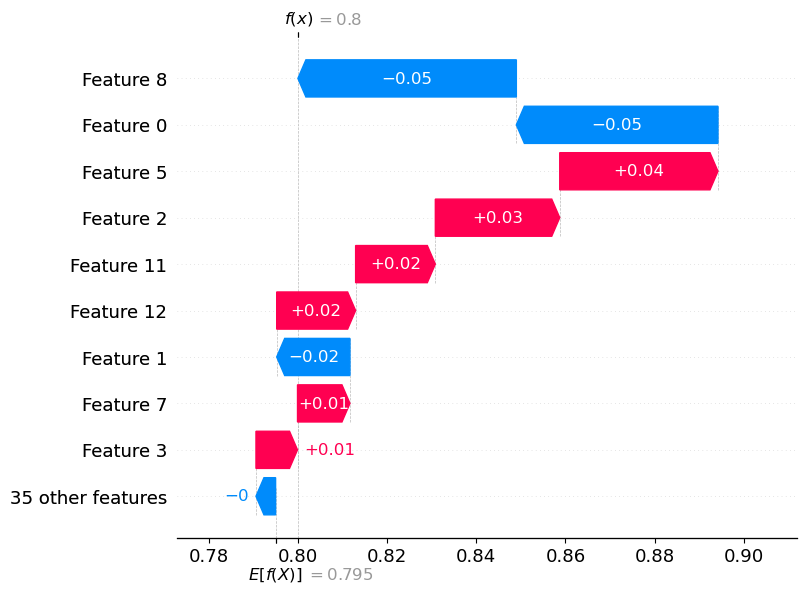

In [38]:
shap.plots._waterfall.waterfall_legacy(shap_kernel_exp.expected_value[1], shap_values_kernel[1][1,:])

# LIME

LIME focuses on local explanations. The idea is: it generates a set of neighbours, on them it trains a linear model.

- Select your instance of interest for which you want to have an explanation of its black box prediction.
- Perturb your dataset and  get the black box predictions for these new points.
- Weight the new samples according to their proximity to the instance of interest.
- Train a weighted, interpretable model on the dataset with the variations.
- Explain the prediction by interpreting the local model.


There are 2 kinds of neighbourhood generation:

- Gaussian
- Lhs (Latin Hypercube Sampling)

We first initialize the lime explainer on our train data, providing the names of our features

In [39]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names = feature_names)

In [40]:
inst = X_test.values[0]

Then we can explain each data point locally
We can see each explanation from the "perspective" of the class that we want to focus on

In [41]:
exp = explainer.explain_instance(inst, bb.predict_proba)
exp.show_in_notebook(show_table=True, show_all=False)

In [42]:
exp = explainer.explain_instance(inst, bb.predict_proba, labels=[0])
exp.show_in_notebook(show_table=True, show_all=False)

We can also "cut" our explanation and modify the visualization

In [43]:
exp = explainer.explain_instance(inst, bb.predict_proba, num_features=5)
exp.show_in_notebook(show_table=True, show_all=False)

You can also manage other options:

- top_labels: if not None, ignore labels and produce explanations for
                the K labels with highest prediction probabilities, where K is
                this parameter.
- num_features: maximum number of features present in explanation
            num_samples: size of the neighborhood to learn the linear model
- distance_metric: the distance metric to use for weights.
- model_regressor: sklearn regressor to use in explanation. Defaults
                to Ridge regression in LimeBase. Must have model_regressor.coef_
                and 'sample_weight' as a parameter to model_regressor.fit()
- sampling_method: Method to sample synthetic data. Defaults to Gaussian
                sampling. Can also use Latin Hypercube Sampling.

We can provide the explanation as a pyplot figure

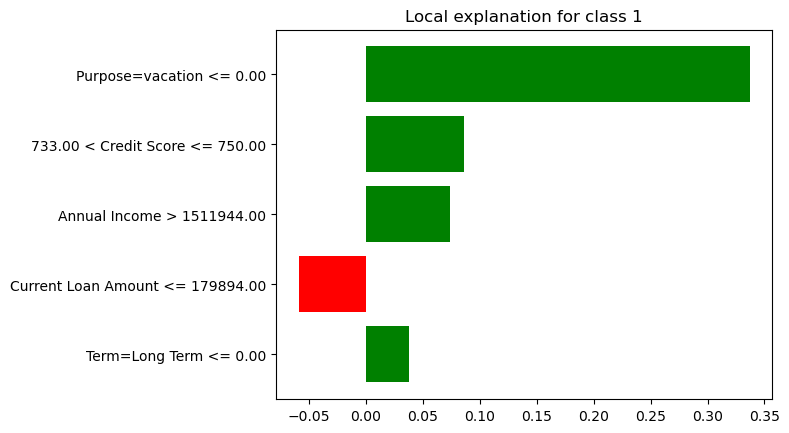

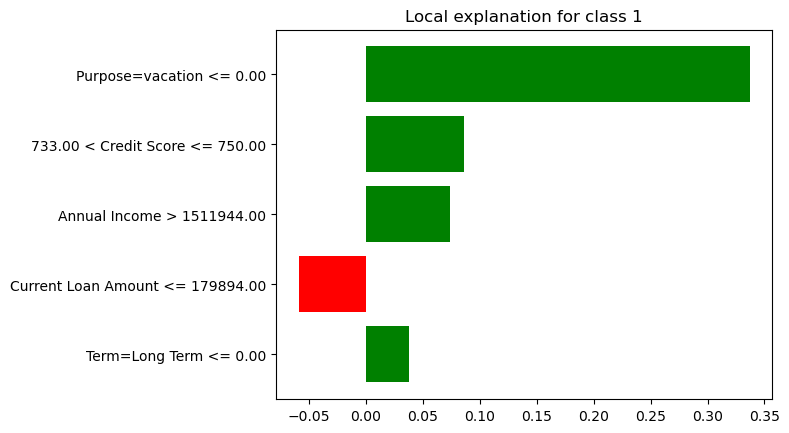

In [44]:
exp.as_pyplot_figure()
#Old line - exp.as_pyplot_figure(label=0)"

Or manipulate the values as a list

In [45]:
exp.as_list()
#Old line - exp.as_list(0)"

[('Purpose=vacation <= 0.00', 0.3369287813370761),
 ('733.00 < Credit Score <= 750.00', 0.086180554617632),
 ('Annual Income > 1511944.00', 0.07377960095635713),
 ('Current Loan Amount <= 179894.00', -0.05921814303835184),
 ('Term=Long Term <= 0.00', 0.03809850290584683)]

In [46]:
exp.as_map()

{1: [(42, 0.3369287813370761),
  (1, 0.086180554617632),
  (2, 0.07377960095635713),
  (0, -0.05921814303835184),
  (11, 0.03809850290584683)]}

# Lore

Lore is an algorithm developed internally to the KDDLab. To use it we will use the xai lib that we imported at the beginning. Note that shap and lime are wrappend in the xai lib, so if you want you can replicate the previous part using the xai lib.

We then use the `sklearn_classifier_wrapper` from xai lib to wrap our black box and make it ready to explain

In [47]:
bbox = sklearn_classifier_wrapper(bb)

Now e could also use the imlpementations of SHAP and Lime that are present in the XAI-lib

In [48]:
explainer = LoreTabularExplainer(bbox)

In [49]:
inst = X_train.iloc[147].values

Lore uses various type of neighborhood generation to provide a local explanation based on factuals and counterfactuals

In [50]:
explainer = LoreTabularExplainer(bbox)
config = {'neigh_type':'rndgen', 'size':1000, 'ocr':0.1, 'ngen':10}
explainer.fit(df, target, config)
exp = explainer.explain(inst)
print(exp)

In [51]:
print('Instance ',inst)
print('True class ',Y_train.iloc[147])
print('Predicted class ',bb.predict(inst.reshape(1, -1)))

Instance  [199518.0 1076.4560893550702 1378276.559842169 6701.3 16.6 14.0 0.0
 96121.0 1483856.0 0.0 0.0 False True False False False True False False
 False False False False False False False False True False False False
 False False False True False False False False False False False False
 False]
True class  1
Predicted class  [1]


In [52]:
exp.plotRules()

In [53]:
exp.plotCounterfactualRules()

# DiCE

In [54]:
import dice_ml
from dice_ml.utils import helpers # helper functions

In [122]:
tesize = int(test_size*df.shape[0])

In [123]:
df_train = df.iloc[:-tesize]
df_test = df.iloc[-tesize:].drop(columns='Loan Status')

In [125]:
# # Dataset for training an ML model
d = dice_ml.Data(dataframe=df_train, continuous_features=numeric_columns, outcome_name=target)

# # Pre-trained ML model
m = dice_ml.Model(bb, backend='sklearn')
# DiCE explanation instance
expdice = dice_ml.Dice(d, m)

In [126]:
e1 = expdice.generate_counterfactuals(df_test[0:1], total_CFs=2)
e1.visualize_as_dataframe(show_only_changes=True)

  0%|          | 0/1 [00:00<?, ?it/s]


ValueError: could not convert string to float: 'True'